In [78]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon, Point
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import dill
import geopandas
import geopandas as gpd
import matplotlib.colors as colors


# JAX
import jax
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

print(jax.__version__)
print(numpyro.__version__)

0.2.17
0.7.1


In [79]:
# Set admin level
admin_level = 2

## Read shape files

In [80]:
shape_new = gpd.read_file(f"data/Shapefiles/zmb_admbnda_adm{admin_level}_dmmu_20201124.shp")
shape_new = shape_new[[f"ADM{admin_level}_EN", 'geometry']]
shape_new['new'] = 1
shape_new

,ADM2_EN,geometry,new
0,Chibombo,"POLYGON ((28.00409 -14.51361, 28.00989 -14.514...",1
1,Chisamba,"POLYGON ((28.65022 -14.38920, 28.65131 -14.389...",1
2,Chitambo,"POLYGON ((29.99949 -12.00267, 30.00002 -12.002...",1
3,Itezhi-tezhi,"POLYGON ((26.99044 -15.46178, 27.20284 -15.468...",1
4,Kabwe,"POLYGON ((28.33593 -14.26089, 28.33684 -14.262...",1
...,...,...,...
110,Sioma,"POLYGON ((23.22303 -16.24968, 23.22304 -16.249...",1
111,Kapiri Mposhi,"POLYGON ((28.97528 -13.77728, 28.97804 -13.777...",1
112,Nchelenge,"POLYGON ((28.98384 -9.11358, 29.01004 -9.12788...",1
113,Shiwamg'andu,"POLYGON ((31.71596 -10.50328, 31.72146 -10.507...",1


<Axes: >

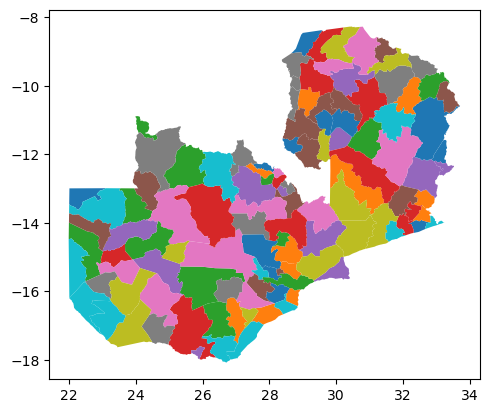

In [81]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
shape_new.plot(ax=ax, column=f"ADM{admin_level}_EN")

<Axes: >

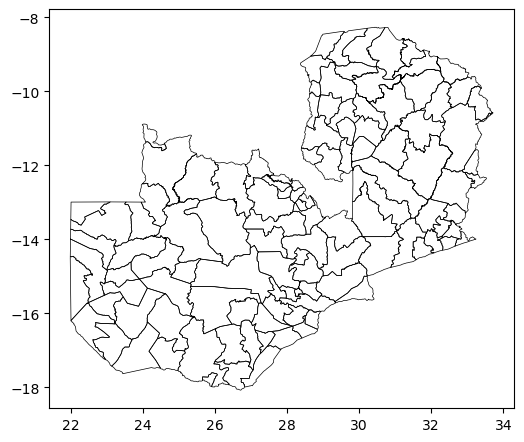

In [82]:
shape_new.boundary.plot(linewidth=0.5,  edgecolor='black', figsize=(6,6))
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/boundaries_after2010.pdf')

In [83]:
# capitalise unit names
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
shape_new[f"ADM{admin_level}_EN"] =  np.array([names_shape_new[i].upper() for i in range(len(names_shape_new))])
shape_new.head(5)

,ADM2_EN,geometry,new
0,CHIBOMBO,"POLYGON ((28.00409 -14.51361, 28.00989 -14.514...",1
1,CHISAMBA,"POLYGON ((28.65022 -14.38920, 28.65131 -14.389...",1
2,CHITAMBO,"POLYGON ((29.99949 -12.00267, 30.00002 -12.002...",1
3,ITEZHI-TEZHI,"POLYGON ((26.99044 -15.46178, 27.20284 -15.468...",1
4,KABWE,"POLYGON ((28.33593 -14.26089, 28.33684 -14.262...",1


In [84]:
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
names_shape_new

array(['CHIBOMBO', 'CHISAMBA', 'CHITAMBO', 'ITEZHI-TEZHI', 'KABWE',
       'LUANO', 'MKUSHI', 'MUMBWA', 'NGABWE', 'SERENJE', 'CHILILABOMBWE',
       'CHINGOLA', 'KALULUSHI', 'KITWE', 'LUANSHYA', 'LUFWANYAMA',
       'MASAITI', 'MPONGWE', 'MUFULIRA', 'NDOLA', 'CHADIZA', 'CHASEFU',
       'CHIPANGALI', 'CHIPATA', 'KASENENGWA', 'KATETE', 'LUMEZI',
       'LUNDAZI', 'MAMBWE', 'NYIMBA', 'PETAUKE', 'SINDA', 'VUBWI',
       'CHEMBE', 'CHIENGI', 'CHIFUNABULI', 'CHIPILI', 'KAWAMBWA', 'LUNGA',
       'MANSA', 'MILENGI', 'MWANSABOMBWE', 'MWENSE', 'SAMFYA', 'CHILANGA',
       'CHIRUNDU', 'CHONGWE', 'KAFUE', 'LUANGWA', 'LUSAKA', 'RUFUNSA',
       'SHIBUYUNJI', 'CHAMA', 'CHINSALI', 'ISOKA', 'KANCHIBIYA',
       'LAVUSHIMANDA', 'MAFINGA', 'MPIKA', 'NAKONDE', 'CHAVUMA',
       'IKELENGE', 'KABOMPO', 'KALUMBILA', 'KASEMPA', 'MANYINGA',
       'MUFUMBWE', 'MUSHINDANO', 'MWINILUNGA', 'SOLWEZI', 'ZAMBEZI',
       'CHILUBI', 'KAPUTA', 'KASAMA', 'LUNTE DISTRICT', 'LUPOSOSHI',
       'LUWINGU', 'MBALA', 'MPU

# Malaria data

In [85]:
infections_new = pd.read_csv(f"../../data/dhs/ZMB_prev_data_admin{admin_level}.csv")
infections_new = infections_new[['unit', 'usage', 'num_rdt', 'num_rdt_positive', 'prev_estimate']]
infections_new = infections_new.rename({'unit': 'area'}, axis='columns')
infections_new = infections_new.sort_values(by=['area'])
infections_new.head(5)

,area,usage,num_rdt,num_rdt_positive,prev_estimate
0,Chadiza,0.592593,43.522101,2.352546,0.054054
1,Chama,0.656690,219.745559,13.109616,0.059658
2,Chasefu,0.491268,157.033307,2.872475,0.018292
3,Chavuma,0.438596,56.444920,5.039725,0.089286
4,Chembe,0.826087,50.954995,0.000000,0.000000


## Merge infections and shape

In [86]:
if (admin_level==2):
    # Create new rows with zero values
    new_rows = pd.DataFrame({'area': ['CHIRUNDU', 'ITEZHI-TEZHI', 'SHIBUYUNJI'],
                             'usage': [0.0, 0.0, 0.0],
                             'num_rdt': [0.0, 0.0, 0.0],
                             'num_rdt_positive': [0.0, 0.0, 0.0],
                             'prev_estimate': [0.0, 0.0, 0.0]})

    # Append new rows to infections_new
    infections_new = pd.concat([infections_new, new_rows])

In [87]:
names_infections_new = infections_new.area.values
shape_new = shape_new.rename({f"ADM{admin_level}_EN": 'area'}, axis='columns')
shape_new = shape_new.sort_values(by=['area'])
shape_new.head(3)
names_shape_new = shape_new['area'].values
print(names_infections_new)
print(names_shape_new)

['Chadiza' 'Chama' 'Chasefu' 'Chavuma' 'Chembe' 'Chibombo' 'Chiengi'
 'Chifunabuli' 'Chikankanta' 'Chilanga' 'Chililabombwe' 'Chilubi'
 'Chingola' 'Chinsali' 'Chipangali' 'Chipata' 'Chipili' 'Chisamba'
 'Chitambo' 'Choma' 'Chongwe' 'Gwembe' 'Ikelenge' 'Isoka' 'Kabompo'
 'Kabwe' 'Kafue' 'Kalabo' 'Kalomo' 'Kalulushi' 'Kalumbila' 'Kanchibiya'
 'Kaoma' 'Kapiri Mposhi' 'Kaputa' 'Kasama' 'Kasempa' 'Kasenengwa' 'Katete'
 'Kawambwa' 'Kazungula' 'Kitwe' 'Lavushimanda' 'Limulunga' 'Livingstone'
 'Luampa' 'Luangwa' 'Luano' 'Luanshya' 'Lufwanyama' 'Lukulu' 'Lumezi'
 'Lundazi' 'Lunga' 'Lunte District' 'Lupososhi' 'Lusaka' 'Luwingu'
 'Mafinga' 'Mambwe' 'Mansa' 'Manyinga' 'Masaiti' 'Mazabuka' 'Mbala'
 'Milengi' 'Mitete' 'Mkushi' 'Mongu' 'Monze' 'Mpika' 'Mpongwe' 'Mporokoso'
 'Mpulungu' 'Mufulira' 'Mufumbwe' 'Mulobezi' 'Mumbwa' 'Mungwi'
 'Mushindano' 'Mwandi' 'Mwansabombwe' 'Mwense' 'Mwinilunga' 'Nakonde'
 'Nalolo' 'Namwala' 'Nchelenge' 'Ndola' 'Ngabwe' 'Nkeyema' 'Nsama'
 'Nyimba' 'Pemba' 'Petauke' 'R

In [88]:
# Re-labelling for admin level 1
if (admin_level==1):
    names_infections_new[6] = 'North-Western'
# convert to uppercase
names_infections_new = [names_infections_new[i].upper() for i in range(len(names_infections_new))]
print(names_infections_new)
print(names_shape_new)

['CHADIZA', 'CHAMA', 'CHASEFU', 'CHAVUMA', 'CHEMBE', 'CHIBOMBO', 'CHIENGI', 'CHIFUNABULI', 'CHIKANKANTA', 'CHILANGA', 'CHILILABOMBWE', 'CHILUBI', 'CHINGOLA', 'CHINSALI', 'CHIPANGALI', 'CHIPATA', 'CHIPILI', 'CHISAMBA', 'CHITAMBO', 'CHOMA', 'CHONGWE', 'GWEMBE', 'IKELENGE', 'ISOKA', 'KABOMPO', 'KABWE', 'KAFUE', 'KALABO', 'KALOMO', 'KALULUSHI', 'KALUMBILA', 'KANCHIBIYA', 'KAOMA', 'KAPIRI MPOSHI', 'KAPUTA', 'KASAMA', 'KASEMPA', 'KASENENGWA', 'KATETE', 'KAWAMBWA', 'KAZUNGULA', 'KITWE', 'LAVUSHIMANDA', 'LIMULUNGA', 'LIVINGSTONE', 'LUAMPA', 'LUANGWA', 'LUANO', 'LUANSHYA', 'LUFWANYAMA', 'LUKULU', 'LUMEZI', 'LUNDAZI', 'LUNGA', 'LUNTE DISTRICT', 'LUPOSOSHI', 'LUSAKA', 'LUWINGU', 'MAFINGA', 'MAMBWE', 'MANSA', 'MANYINGA', 'MASAITI', 'MAZABUKA', 'MBALA', 'MILENGI', 'MITETE', 'MKUSHI', 'MONGU', 'MONZE', 'MPIKA', 'MPONGWE', 'MPOROKOSO', 'MPULUNGU', 'MUFULIRA', 'MUFUMBWE', 'MULOBEZI', 'MUMBWA', 'MUNGWI', 'MUSHINDANO', 'MWANDI', 'MWANSABOMBWE', 'MWENSE', 'MWINILUNGA', 'NAKONDE', 'NALOLO', 'NAMWALA', 'NC

In [89]:
names_shape_new_lst = list(names_shape_new)
lst = [names_shape_new_lst[i] not in names_infections_new for i in range(len(names_shape_new))]
[names_shape_new_lst[i] for i in range(len(lst)) if lst[i] == True]

[]

In [90]:
names_infections_lst = list(names_infections_new)
lst2 = [names_infections_lst[i] not in names_shape_new for i in range(len(names_infections_new))]
[names_infections_lst[i] for i in range(len(lst2)) if lst2[i] == True]

[]

In [91]:
names_infections_new

['CHADIZA',
 'CHAMA',
 'CHASEFU',
 'CHAVUMA',
 'CHEMBE',
 'CHIBOMBO',
 'CHIENGI',
 'CHIFUNABULI',
 'CHIKANKANTA',
 'CHILANGA',
 'CHILILABOMBWE',
 'CHILUBI',
 'CHINGOLA',
 'CHINSALI',
 'CHIPANGALI',
 'CHIPATA',
 'CHIPILI',
 'CHISAMBA',
 'CHITAMBO',
 'CHOMA',
 'CHONGWE',
 'GWEMBE',
 'IKELENGE',
 'ISOKA',
 'KABOMPO',
 'KABWE',
 'KAFUE',
 'KALABO',
 'KALOMO',
 'KALULUSHI',
 'KALUMBILA',
 'KANCHIBIYA',
 'KAOMA',
 'KAPIRI MPOSHI',
 'KAPUTA',
 'KASAMA',
 'KASEMPA',
 'KASENENGWA',
 'KATETE',
 'KAWAMBWA',
 'KAZUNGULA',
 'KITWE',
 'LAVUSHIMANDA',
 'LIMULUNGA',
 'LIVINGSTONE',
 'LUAMPA',
 'LUANGWA',
 'LUANO',
 'LUANSHYA',
 'LUFWANYAMA',
 'LUKULU',
 'LUMEZI',
 'LUNDAZI',
 'LUNGA',
 'LUNTE DISTRICT',
 'LUPOSOSHI',
 'LUSAKA',
 'LUWINGU',
 'MAFINGA',
 'MAMBWE',
 'MANSA',
 'MANYINGA',
 'MASAITI',
 'MAZABUKA',
 'MBALA',
 'MILENGI',
 'MITETE',
 'MKUSHI',
 'MONGU',
 'MONZE',
 'MPIKA',
 'MPONGWE',
 'MPOROKOSO',
 'MPULUNGU',
 'MUFULIRA',
 'MUFUMBWE',
 'MULOBEZI',
 'MUMBWA',
 'MUNGWI',
 'MUSHINDANO',
 'MWAN

In [92]:
infections_new.area = names_infections_new 
infections_new

,area,usage,num_rdt,num_rdt_positive,prev_estimate
0,CHADIZA,0.592593,43.522101,2.352546,0.054054
1,CHAMA,0.656690,219.745559,13.109616,0.059658
2,CHASEFU,0.491268,157.033307,2.872475,0.018292
3,CHAVUMA,0.438596,56.444920,5.039725,0.089286
4,CHEMBE,0.826087,50.954995,0.000000,0.000000
...,...,...,...,...,...
110,ZAMBEZI,0.729241,121.081102,1.686360,0.013928
111,ZIMBA,0.542139,89.358756,9.592446,0.107348
0,CHIRUNDU,0.000000,0.000000,0.000000,0.000000
1,ITEZHI-TEZHI,0.000000,0.000000,0.000000,0.000000


In [93]:
shape_new = shape_new.merge(infections_new, how='left', left_on='area', right_on='area')
shape_new.head(3)

,area,geometry,new,usage,num_rdt,num_rdt_positive,prev_estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,43.522101,2.352546,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,219.745559,13.109616,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157.033307,2.872475,0.018292


In [94]:
np.sum(np.isnan(shape_new.num_rdt))

0

In [95]:
s_new = shape_new.rename({'num_rdt': 'n_obs', 'num_rdt_positive': 'y', 'prev_estimate': 'estimate'}, axis='columns')
s_new['y'] = round(s_new['y']).astype(int)
s_new['n_obs'] = round(s_new['n_obs']).astype(int)
s_new.head(3)

,area,geometry,new,usage,n_obs,y,estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,44,2,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,220,13,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157,3,0.018292


Text(0.5, 1.0, 'usage')

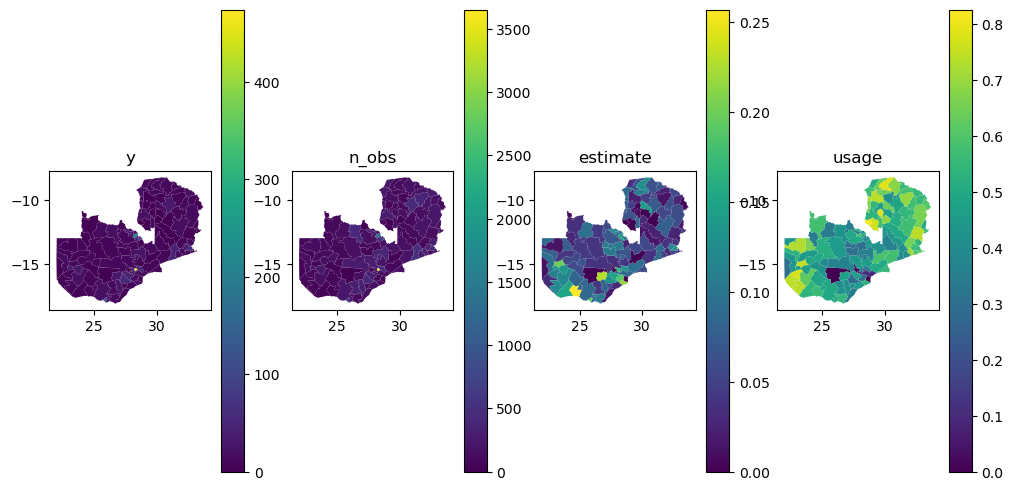

In [96]:
fig, ax = plt.subplots(1, 4, figsize=(12,6))
s_new.plot(column="y", ax=ax[0], legend=True)
s_new.plot(column="n_obs", ax=ax[1], legend=True)
s_new.plot(column="estimate", ax=ax[2], legend=True)
s_new.plot(column="usage", ax=ax[3], legend=True)
ax[0].set_title( 'y')
ax[1].set_title( 'n_obs')
ax[2].set_title( 'estimate')
ax[3].set_title( 'usage')

In [97]:
if (admin_level==2):
    # Check y and n_obs for capital, Lusaka
    lusaka_data = s_new[s_new['area'] == 'LUSAKA']
    print(lusaka_data[['y', 'n_obs']])

      y  n_obs
58  474   3653


In [98]:
del shape_new
del infections_new

## Computational grid

In [99]:
x_min, x_max, y_min, y_max = 21.5, 34, -19, -8
dy = y_max - y_min
dx = x_max - x_min
factor = dy / dx
n_x = 40
n_y = math.ceil(n_x * factor)
print(n_x)
print(n_y)
print(n_x * n_y)

x_grid = np.linspace(x_min, x_max, n_x, endpoint=True)
y_grid = np.linspace(y_min, y_max, n_y, endpoint=True)

# full coordinate arrays
x_coords, y_coords = np.meshgrid(x_grid, y_grid)
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

df = pd.DataFrame({'Latitude': y_coords, 'Longitude': x_coords})

grid_pts = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

x = jnp.array([x_coords, y_coords]).transpose((1, 0))
print(x.shape)

40
36
1440
(1440, 2)


<Axes: >

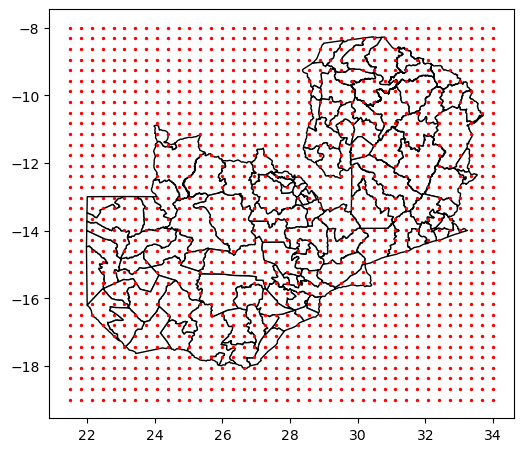

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s_new.plot(ax=ax, color='white', edgecolor='black')
grid_pts.plot(ax=ax, marker='o', color='red', markersize=2)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/comp_grid.pdf')

In [101]:
# def pol_pts(shape, grid_pts):
#     grid_pts.set_crs(epsg=4326, inplace=True);
#     grid_pts.crs == shape.crs

#     n_pol = len(shape.geometry)
#     n_pts = len(grid_pts.geometry)

#     pl_pt = np.zeros((n_pol, n_pts), dtype=int)

#     pt_which_pol = np.zeros(n_pts, dtype=int)

#     for i_pol in range(n_pol):
#         pol = shape.geometry[i_pol]
#         for j_pts in range(n_pts):
#             pt = grid_pts.geometry[j_pts]
#             if pol.contains(pt):
#                 pl_pt[i_pol, j_pts] = 1
#                 pt_which_pol[j_pts] = i_pol + 1 # note the enumeration!

#     return([pl_pt, pt_which_pol])

def pol_pts(shape, grid_pts, min_pts=10):
    grid_pts.set_crs(epsg=4326, inplace=True);
    grid_pts.crs == shape.crs

    n_pol = len(shape.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)

    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol in range(n_pol):
        pol = shape.geometry[i_pol]
        for j_pts in range(n_pts):
            pt = grid_pts.geometry[j_pts]
            if pol.contains(pt):
                pl_pt[i_pol, j_pts] = 1
                pt_which_pol[j_pts] = i_pol + 1 # note the enumeration!


    # ensure a minimum number of points

    pol_sums = np.sum(pl_pt, axis=1)

    fix_pols = np.where(pol_sums<min_pts)[0]

    if fix_pols.size > 0:

      for i_pol in fix_pols:

        # print(f'i_pol:{i_pol}')

        polygon = shape.geometry[i_pol]
        no_points = pol_sums[i_pol]

        extra_len = min_pts - no_points
        minx, miny, maxx, maxy = polygon.bounds
        extra_y_coords = []
        extra_x_coords = []

        main_rng_key = random.PRNGKey(44)

        # print(extra_len)

        while extra_len > 0:
            main_rng_key, rng_key_pts = random.split(main_rng_key)
            random_point_coords = [
                random.uniform(rng_key_pts, (1,), minval=minx, maxval=maxx)[0],
                random.uniform(rng_key_pts, (1,), minval=miny, maxval=maxy)[0]
            ]
            random_point = Point(float(random_point_coords[0]), float(random_point_coords[1]))

            if polygon.contains(random_point):
              # print('Contains random point')
              extra_y_coords.append(random_point.y)
              extra_x_coords.append(random_point.x)
              extra_len -= 1

        # add extra points to grid

        # Create DataFrame for new points
        extra_df = pd.DataFrame({'Latitude': extra_y_coords, 'Longitude': extra_x_coords})
        extra_grid_pts = gpd.GeoDataFrame(extra_df, geometry=gpd.points_from_xy(extra_df.Longitude, extra_df.Latitude))

        # Set CRS for the new GeoDataFrame
        extra_grid_pts.set_crs(epsg=4326, inplace=True)

        # Concatenate the original and new GeoDataFrames
        grid_pts = pd.concat([grid_pts, extra_grid_pts]).reset_index(drop=True)


      # Amend pl_pt and pt_which_pol (outside polygon loop)
      pl_pt, pt_which_pol, _ = pol_pts(shape, grid_pts, min_pts)

    return([pl_pt, pt_which_pol, grid_pts])


In [102]:
pol_pt_new, pt_which_pol_new, grid_pts_new = pol_pts(s_new, grid_pts, min_pts=10)
pol_sums_new = np.sum(pol_pt_new, axis=1) # how many points in each polygon
# print(all(item > 0 for item in pol_sums_new)) # in each polygon there is at least one point
print(all(item >= 10 for item in pol_sums_new)) # in each polygon there is at least 10 points
grid_pts_new['pt_which_pol_new'] = pt_which_pol_new
grid_pts_new

True


,Latitude,Longitude,geometry,pt_which_pol_new
0,-19.000000,21.500000,POINT (21.50000 -19.00000),0
1,-19.000000,21.820513,POINT (21.82051 -19.00000),0
2,-19.000000,22.141026,POINT (22.14103 -19.00000),0
3,-19.000000,22.461538,POINT (22.46154 -19.00000),0
4,-19.000000,22.782051,POINT (22.78205 -19.00000),0
...,...,...,...,...
2013,-17.455769,26.790142,POINT (26.79014 -17.45577),115
2014,-17.507141,26.722168,POINT (26.72217 -17.50714),115
2015,-17.777426,26.364519,POINT (26.36452 -17.77743),115
2016,-17.394756,26.870876,POINT (26.87088 -17.39476),115


In [103]:
new_y_coords = grid_pts_new['Latitude']
new_x_coords = grid_pts_new['Longitude']
new_x = jnp.array([new_x_coords, new_y_coords]).transpose((1, 0))
print(new_x.shape)

(2018, 2)


In [104]:
grid_pts = grid_pts_new
grid_pts.shape

(2018, 4)

In [105]:
# pol_pt_old, pt_which_pol_old = pol_pts(s_old, grid_pts)
# pol_sums_old = np.sum(pol_pt_old, axis=1) # how many points in each polygon
# print(all(item > 0 for item in pol_sums_old)) # in each polygon there is at least one point
# grid_pts['pt_which_pol_old'] = pt_which_pol_old
# grid_pts.head(2)

In [106]:
grid_pts['in_out_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 'out' if x==0 else 'in')
grid_pts['marker_size_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 1 if x==0 else 12)
n_pol_new = len(s_new.geometry)

# grid_pts['in_out_old'] = grid_pts['pt_which_pol_old'].apply(lambda x: 'out' if x==0 else 'in')
# grid_pts['marker_size_old'] = grid_pts['pt_which_pol_old'].apply(lambda x: 1 if x==0 else 12)
# n_pol_old = len(s_old.geometry)

In [107]:
cmap = plt.cm.prism  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

<Axes: >

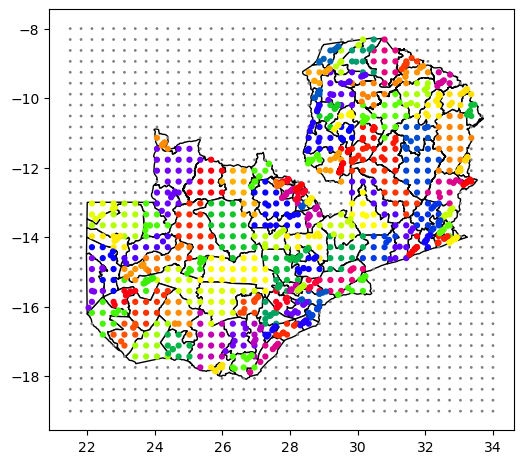

In [108]:
fig, ax2 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
s_new.plot(ax=ax2, color='white', edgecolor='black')
grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)
#ax2.title.set_text('After 2010')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/grid_polygons_after.pdf')

In [109]:
s_new.head(3)

,area,geometry,new,usage,n_obs,y,estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,44,2,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,220,13,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157,3,0.018292


In [110]:
type(s_new)

geopandas.geodataframe.GeoDataFrame

In [111]:
s = s_new
# s = pd.concat([s_old, s_new])
# s.head()
# print(s.shape)

# Traditional prevalence model

In [112]:
# draw GP samples on the grid

def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [113]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

In [136]:
args = {'n_obs': jnp.array(s.n_obs),
        "x": new_x,
        "gp_kernel": exp_sq_kernel,
        "batch_size": 1,
        "jitter": 1e-4,
        "M_new": pol_pt_new,
        
        # MCMC setup
        "num_warmup": 200,
        "num_mcmc_samples": 3000,  

        # hyperparameters
        "hyperprior_ls_name": "InverseGamma(3,3)",
        "hyperprior_var_name": "HalfNormal(0.05)",
        "hyperprior_ls": dist.InverseGamma(3, 3),
        "hyperprior_var": dist.HalfNormal(0.05),
}      


In [137]:
model_specs =('_admin' + str(admin_level)+
              '_mcmcsamp' + str(args['num_mcmc_samples'])+
             '_ls' + args['hyperprior_ls_name']+
             '_var' + args['hyperprior_var_name'])
print('Model specifications:', model_specs)

Model specifications: _admin2_mcmcsamp3000_lsInverseGamma(3,3)_varHalfNormal(0.05)


In [138]:
# Create the new directory
os.makedirs('figures/ZMB2018_aggGP'+model_specs, exist_ok=True)

In [115]:
def prev_model_gp_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    var = numpyro.sample("kernel_var", dist.HalfNormal(0.05))
    k = gp_kernel(x, x, var, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    # gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))
    gp_aggr = numpyro.deterministic('gp_aggr', gp_aggr_new)

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))

    # linear predictor
    lp = b0 + gp_aggr
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [116]:
rng_key, rng_key_predict = random.split(random.PRNGKey(1))
prev_predictive = Predictive(prev_model_gp_aggr, num_samples=args["batch_size"])
gp_draws = prev_predictive(rng_key_predict, args)['f']

In [117]:
rng_key, rng_key_predict = random.split(random.PRNGKey(3))
kernel = NUTS(prev_model_gp_aggr)
n_warm = 200
n_samps = 3000
mcmc_gp_aggr = MCMC(kernel, num_warmup=n_warm, num_samples=n_samps)

In [118]:
# inference
run_mcmc = True

if run_mcmc:
    start = time.time()
    mcmc_gp_aggr.run(rng_key, args, y = jnp.array(s.y))
    t_elapsed = time.time() - start

sample: 100%|██████████| 3200/3200 [65:42:56<00:00, 73.93s/it, 127 steps of size 4.73e-02. acc. prob=0.65]      


In [119]:
# save MCMC
with open(f"MCMCs/prev_model_gp_aggr_joint_iter{n_samps}_zmb2018_admin{admin_level}_grid{n_x}_long", 'wb') as file:
   dill.dump(mcmc_gp_aggr, file)

In [120]:
# load MCMC
with open(f"MCMCs/prev_model_gp_aggr_joint_iter{n_samps}_zmb2018_admin{admin_level}_grid{n_x}_long", 'rb') as file:
    mcmc_gp_agg = dill.load(file)

In [132]:
import pickle
import numpy as np
import numpyro
from numpyro.diagnostics import summary
import os

# Assuming mcmc_gp_aggr and t_elapsed are defined elsewhere in your code

if run_mcmc:
    # Get samples and print summary
    prev_samples_aggr = mcmc_gp_aggr.get_samples()
    mcmc_gp_aggr.print_summary(exclude_deterministic=False)
    
    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    print("\nMCMC elapsed time:", round(t_elapsed / 60), "min")
    print("\nMCMC elapsed time:", round(t_elapsed / (60 * 60)), "h")
    
    # Get MCMC diagnostics summary
    ss = summary(mcmc_gp_aggr.get_samples(group_by_chain=True))
    r_gp_aggr = np.nanmean(ss['gp_aggr']['n_eff'])
    print("Average ESS for all aggGP effects : " + str(round(r_gp_aggr)))
    
    r_gp_aggr_new = np.nanmean(ss['gp_aggr_new']['n_eff'])
    print("Average ESS for all aggGP-new effects : " + str(round(r_gp_aggr_new)))
    print("Max r_hat for all aggGP-new effects : " + str(round(np.nanmax(ss['gp_aggr_new']['r_hat']), 2)))
    
    r_hat_kernel_length = round(ss['kernel_length']['r_hat'], 2)
    print("kernel_length R-hat : " + str(r_hat_kernel_length))
    
    r_hat_kernel_var = round(ss['kernel_var']['r_hat'], 2)
    print("kernel_var R-hat : " + str(r_hat_kernel_var))
    
    # Save results in a pickle file
    with open(f'figures/ZMB2018_aggGP_mcmc_summary_text.pkl', 'wb') as f:
        pickle.dump(prev_samples_aggr, f)

    # Save results in a .tex file
    with open('figures/ZMB2018_aggGP_mcmc_summary_latex.tex', 'w') as f:
        f.write(r"""
\documentclass{article}
\begin{document}
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
Average ESS for all aggGP effects & """ + str(round(r_gp_aggr)) + r""" \\
\hline
Average ESS for all aggGP-new effects & """ + str(round(r_gp_aggr_new)) + r""" \\
\hline
Max r\_hat for all aggGP-new effects & """ + str(round(np.nanmax(ss['gp_aggr_new']['r_hat']), 2)) + r""" \\
\hline
kernel\_length R-hat & """ + str(r_hat_kernel_length) + r""" \\
\hline
kernel\_var R-hat & """ + str(r_hat_kernel_var) + r""" \\
\hline
\end{tabular}
\caption{MCMC Results}
\label{table:mcmc_results}
\end{table}
\end{document}
        """)

# Load and verify results
with open(f'figures/ZMB2018_aggGP_mcmc_summary_text.pkl', 'rb') as f:
    loaded_samples_aggr = pickle.load(f)

# Print to verify pickle file
print(loaded_samples_aggr)

# Check and print .tex file content to verify
with open(f'figures/ZMB2018_aggGP_mcmc_summary_latex.tex', 'r') as f:
    tex_content = f.read()

print(tex_content)

# Optionally, check if the .tex file exists
if os.path.exists('mcmc_results.tex'):
    print(f'figures/ZMB2018_aggGP_mcmc_summary_latex.tex')
else:
    print("Error: .tex file was not saved.")



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              b0     -2.77      0.11     -2.77     -2.96     -2.59    531.83      1.00
            f[0]     -0.00      0.09     -0.00     -0.16      0.15   4807.91      1.00
            f[1]     -0.00      0.09     -0.00     -0.15      0.15   3988.09      1.00
            f[2]      0.00      0.09      0.00     -0.15      0.15   4145.57      1.00
            f[3]      0.00      0.09      0.00     -0.15      0.15   3531.04      1.00
            f[4]     -0.00      0.09      0.00     -0.16      0.14   3356.54      1.00
            f[5]     -0.00      0.09     -0.00     -0.16      0.15   3598.82      1.00
            f[6]     -0.00      0.09     -0.00     -0.15      0.16   4149.87      1.00
            f[7]     -0.00      0.10     -0.00     -0.18      0.14   4256.94      1.00
            f[8]      0.00      0.09      0.00     -0.15      0.16   4474.94      1.00
            f[9]      0.00      0.09      

array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>]], dtype=object)

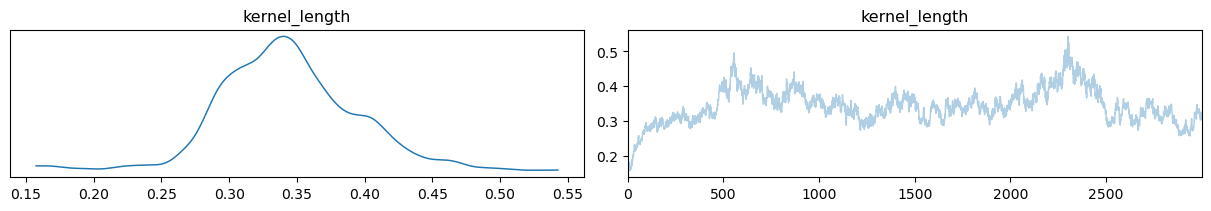

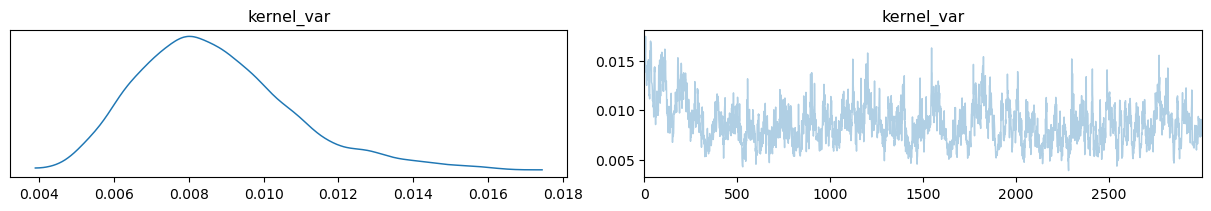

In [123]:
import arviz as az
prev_samples_az_gp = az.from_numpyro(mcmc_gp_aggr)
az.plot_trace(prev_samples_az_gp,  var_names=("kernel_length"))

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/arviz_length.pdf')

az.plot_trace(prev_samples_az_gp,  var_names=("kernel_var"))

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/arviz_var.pdf')

In [128]:
# Text content
content = (
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all aggVAE effects: {round(r)}\n"
    f"Max r_hat for all aggVAE-new effects: {round(r_hat_new, 2)}\n"
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
)

# LaTeX table content
latex_content = r"""
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all aggVAE effects & """ + f"{round(r)}" + r""" \\
\hline
Average ESS for all aggVAE-new effects & """ + f"{round(ess_new)}" + r""" \\
\hline
Max r\_hat for all aggVAE-new effects & """ + f"{round(r_hat_new, 2)}" + r""" \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all VAE-CAR effects & """ + f"{round(r)}" + r""" \\
\hline
\end{tabular}
\caption{Summary of MCMC Results}
\label{table:mcmc_summary}
\end{table}
"""

# Save the text content to a pickle file
text_file_name = f'figures/ZMB2018_aggGP_mcmc_summary_text.pkl'
with open(text_file_name, 'wb') as text_file:
    pickle.dump(content, text_file)

# Save the LaTeX content to a separate pickle file
latex_file_name = f'figures/ZMB2018_aggGP_mcmc_summary_latex.pkl'
with open(latex_file_name, 'wb') as latex_file:
    pickle.dump(latex_content, latex_file)

print(f"Text content has been saved to {text_file_name}")
print(f"LaTeX content has been saved to {latex_file_name}")

# To load the text content back from the pickle file (for verification)
with open(text_file_name, 'rb') as text_file:
    loaded_text_content = pickle.load(text_file)
    print("Loaded text content:")
    print(loaded_text_content)

# To load the LaTeX content back from the pickle file (for verification)
with open(latex_file_name, 'rb') as latex_file:
    loaded_latex_content = pickle.load(latex_file)
    print("Loaded LaTeX content:")
    print(loaded_latex_content)

NameError: name 'ess_new' is not defined

In [124]:
# posterior predictive
prev_posterior_predictive_gp = Predictive(prev_model_gp_aggr, prev_samples_aggr)(random.PRNGKey(1), args)

theta_samps_gp = prev_posterior_predictive_gp['theta']

In [125]:
theta_samps_gp.shape
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp

theta_observed = s['estimate']
theta_estimated_gp = s['theta_gp']

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

# n_old, _= s_old.shape
n_new, _= s_new.shape

# fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[0:n_old].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

# ax[0].set_title( 'Admin2: Observed prevalence')
# ax[1].set_title( 'Before: Estimated prevalence (aggregated GP)')

Text(0.5, 1.0, 'Admin 2: Estimated prevalence (aggregated GP)')

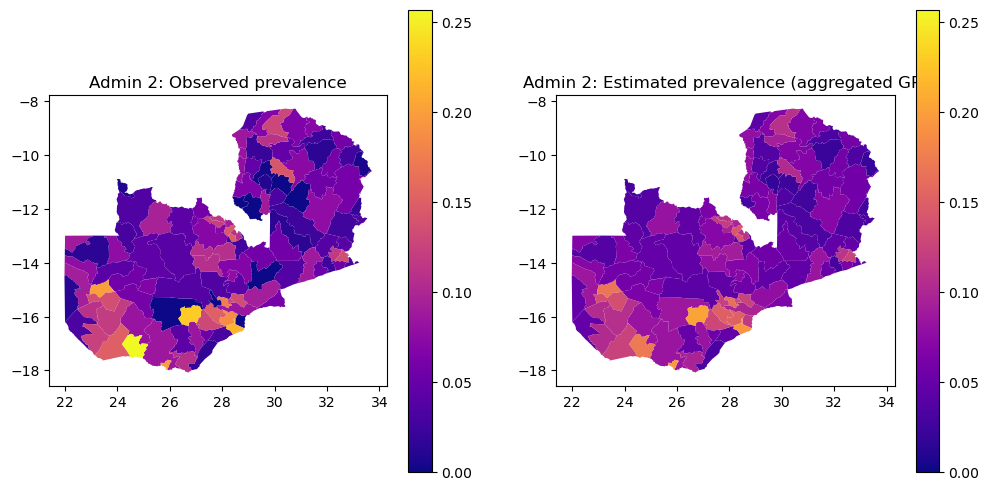

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[n_old:(n_old + n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[n_old:(n_old + n_new)].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title( 'Admin 2: Observed prevalence')
ax[1].set_title( 'Admin 2: Estimated prevalence (aggregated GP)')

Text(0.5, 1.0, 'Admin 2')

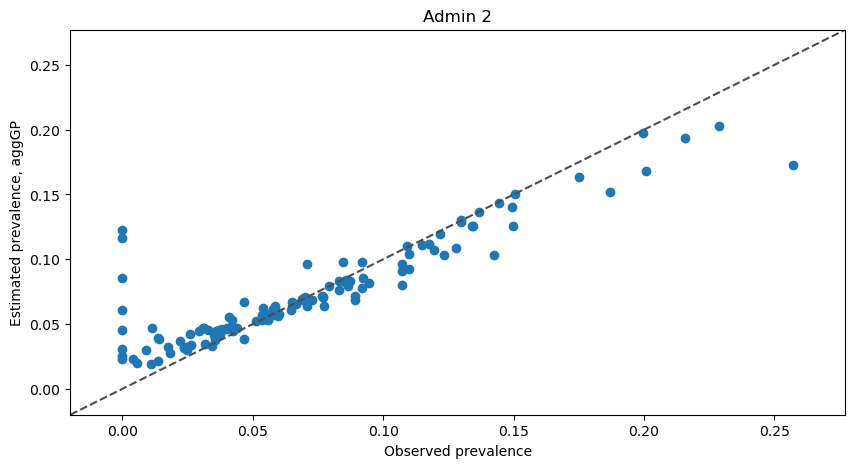

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# ax[0].scatter(s[0:n_old].estimate, s[0:n_old].theta_gp)
# ax[0].set_ylim(_min-0.02, _max+0.02)
# ax[0].set_xlim(_min-0.02, _max+0.02)
# ax[0].axline((1, 1), slope=1, ls="--", c=".3")
# ax[0].set_xlabel("Observed prevalence")
# ax[0].set_ylabel("Estimated prevalence")
# ax[0].set_title("Before 2010")

# ax[1].scatter(s[n_old:(n_old + n_new)].estimate, s[n_old:(n_old + n_new)].theta_gp)
ax.scatter(s.estimate, s.theta_gp)
ax.set_ylim(_min-0.02, _max+0.02)
ax.set_xlim(_min-0.02, _max+0.02)
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.set_xlabel("Observed prevalence")
ax.set_ylabel("Estimated prevalence, aggGP")
ax.set_title("Admin 2")

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/est_obs_gp.pdf')

# Train VAE

In [ ]:
args = {'n_obs': jnp.array(s.n_obs),
        "x": x,
        "gp_kernel": exp_sq_kernel,
        "jitter": 1e-4,
        # "M_old": pol_pt_old,
        "M_new": pol_pt_new,

        # VAE training
        "rng_key": random.PRNGKey(5),
        "num_epochs": 50,
        #"learning_rate": 1.0e-3,
        "learning_rate": 0.0005,
        "batch_size": 100,
        "hidden_dim": 50,
        "z_dim": 40,
        "num_train": 100,
        "num_test":100,
        "vae_var": 1
}

In [ ]:
def gp_aggr(args):

    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    # M_old = args["M_old"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    var = numpyro.sample("kernel_var", dist.HalfNormal(0.05))
    k = gp_kernel(x, x, var, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    # gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f))
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    # gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))
    gp_aggr = numpyro.deterministic('gp_aggr', gp_aggr_new)

In [ ]:
# aggGP: prior predictive

rng_key, rng_key_ = random.split(random.PRNGKey(4))
agg_gp_predictive = Predictive(gp_aggr, num_samples=5)
agg_gp_preds = agg_gp_predictive(rng_key_, args)
agg_gp_draws = agg_gp_preds['gp_aggr']

In [ ]:
agg_gp_draws.shape

(5, 115)

In [ ]:
# s_old_plot = s[0:n_old].copy()

# fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_old_plot[nm] = agg_gp_draws[i,0:n_old]
#     s_old_plot.plot(column=nm, ax=axs[i], legend=True)
#     axs[i].set_title( 'aggGP-prior' + str(i))

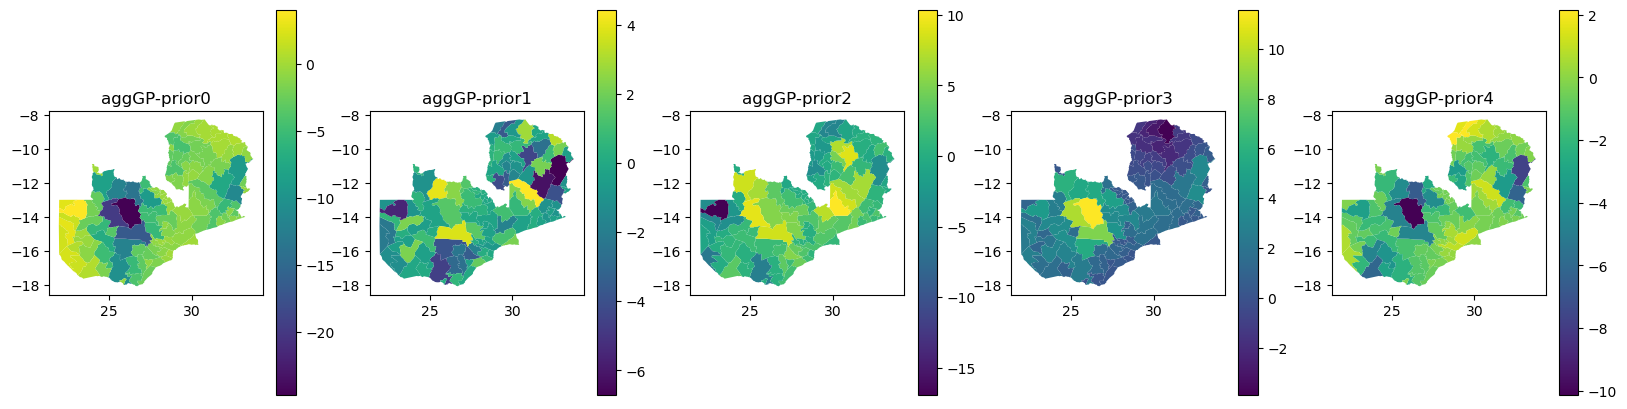

In [ ]:
# s_new_plot = s[n_old:(n_old + n_new)].copy()
s_new_plot = s.copy()

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'gp_aggr_' + str(i)
    # s_new_plot[nm] = agg_gp_draws[i,n_old:(n_old + n_new)]
    s_new_plot[nm] = agg_gp_draws[i,:]
    s_new_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'aggGP-prior' + str(i))

In [ ]:
def vae_encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Elu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder( hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Elu,
        stax.Dense(out_dim, W_init=stax.randn())
    )

def vae_model(batch, hidden_dim, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder( hidden_dim, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((z_dim,)), jnp.ones((z_dim,))))
    gen_loc = decode(z)
    numpyro.sample("obs", dist.Normal(gen_loc, args["vae_var"]), obs=batch)


def vae_guide(batch, hidden_dim,  z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

In [ ]:
@jit
def epoch_train(rng_key, svi_state, num_train):

    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val # val -- svi_state
        batch = agg_gp_predictive(rng_key_i, args)['gp_aggr']
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state)) #fori_loop(lower, upper, body_fun, init_val)

@jit
def eval_test(rng_key, svi_state, num_test):

    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = agg_gp_predictive(rng_key_i, args)['gp_aggr']
        loss = svi.evaluate(svi_state, batch) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

In [ ]:
adam = optim.Adam(step_size=args["learning_rate"])

svi = SVI(vae_model, vae_guide, adam, RenyiELBO(),
          hidden_dim=args["hidden_dim"],
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = agg_gp_predictive(rng_key_, args)['gp_aggr']
svi_state = svi.init(rng_key_init, init_batch)

In [ ]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

test_loss_list = []

for i in range(args['num_epochs']):

    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)

    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print("Epoch {}: loss = {} ({:.2f} s.)".format(i, test_loss, time.time() - t_start))

    if math.isnan(test_loss): break

Current Time = 23:28:11
Epoch 0: loss = 22.770248413085938 (2936.16 s.)


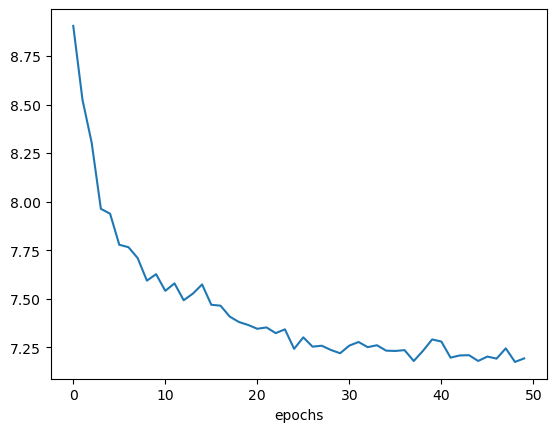

In [ ]:
plt.figure()
plt.plot(np.arange(0, len(test_loss_list), 1), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.show()

In [ ]:
decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

In [ ]:
args["vae_var"]

1

In [ ]:
# Save
with open('decoders/decoder_joint_non_std_var{}_iter50'.format(args["vae_var"]), 'wb') as file:
   pickle.dump(decoder_params, file)

In [ ]:
# Load
with open('decoders/decoder_joint_non_std_var1_iter50', 'rb') as file:
   decoder_params = pickle.load(file)
   print(len(decoder_params))

args["decoder_params"] = decoder_params

3


In [ ]:
N = init_batch.shape[1]
print(N)

115


In [ ]:
decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

z_dim, hidden_dim = decoder_params[0][0].shape

decoder_nn = vae_decoder(hidden_dim, N)

# check output of the decoder
for i in range(5):
    z = jnp.ones(z_dim) + i
    print(decoder_nn[1](decoder_params, z)[0:4])

[3.2066111e-04 1.4334104e+00 2.7933126e-02 1.0304883e-02]
[3.5040663e-04 2.2868705e+00 2.0057721e-02 9.5195755e-02]
[-2.9123384e-03  3.0115998e+00  6.8167890e-03  2.0841329e-01]
[-0.00679178  3.721071   -0.00632205  0.33722767]
[-0.01032787  4.4509463  -0.01777043  0.47520193]


In [ ]:
def vae_sample(args):

    decoder_params = args["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape

    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder( hidden_dim, N)
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn[1](decoder_params, z))

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
vae_predictive = Predictive(vae_sample, num_samples=12)
vae_draws = vae_predictive(rng_key_predict, args)['vae_aggr']

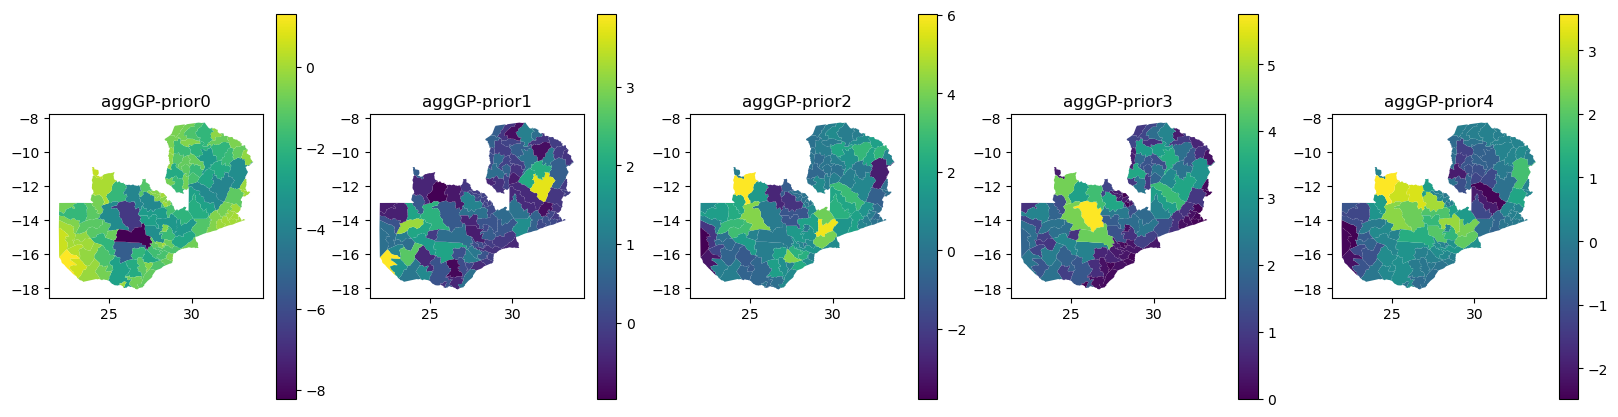

In [ ]:
# s_new_plot = s[n_old:(n_old + n_new)].copy()
s_new_plot = s.copy()

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'gp_aggr_' + str(i)
    # s_new_plot[nm] = agg_gp_draws[i,n_old:(n_old + n_new)]
    s_new_plot[nm] = agg_gp_draws[i,:]
    s_new_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'aggGP-prior' + str(i))

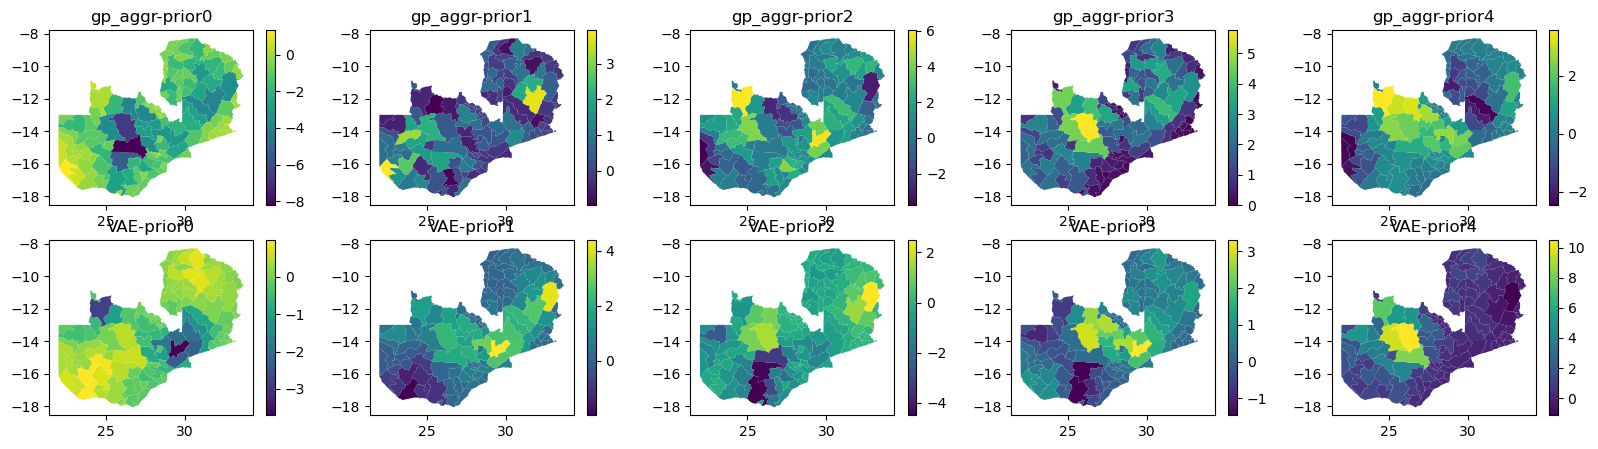

In [ ]:
# new
fig, axs = plt.subplots(2, 5, figsize=(20, 5))

for i in range(5):
    nm = 'gp_aggr_' + str(i)
    s_new_plot.plot(column=nm, ax=axs[0,i], legend=True)
    axs[0,i].set_title( 'gp_aggr-prior' + str(i))

for i in range(5):
    nm = 'vae_draw_' + str(i)
    # s_new_plot[nm] = vae_draws[i,n_old:(n_old + n_new)]
    s_new_plot[nm] = vae_draws[i,:]
    s_new_plot.plot(column=nm, ax=axs[1,i], legend=True)
    axs[1,i].set_title( 'VAE-prior' + str(i))

In [ ]:
(x_coords[1] - x_coords[0]) * (y_coords[40] - y_coords[39])

0.10073260073260057

In [ ]:
rng_key, rng_key_ = random.split(random.PRNGKey(4))

agg_gp_predictive = Predictive(gp_aggr, num_samples=100)
agg_gp_preds = agg_gp_predictive(rng_key_, args)
agg_gp_draws = agg_gp_preds['gp_aggr']

vae_predictive = Predictive(vae_sample, num_samples=100)
vae_draws = vae_predictive(rng_key_predict, args)['vae_aggr']

m_vae = np.cov(np.transpose(vae_draws))
m_gp = np.cov(np.transpose(agg_gp_draws))

Text(0.5, 1.0, 'VAE covariance matrix')

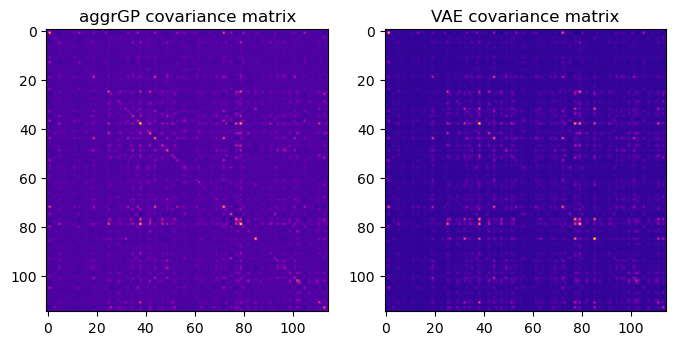

In [ ]:
cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
#axs[0].axis('off')
axs[0].set_title('aggrGP covariance matrix')

axs[1].imshow(m_vae, cmap=cmap_choice)
#axs[1].axis('off')
axs[1].set_title('VAE covariance matrix')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_cov_matrices.pdf')

## Prevalence model - VAE

In [ ]:
def prev_model_vae_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]

    # random effect
    decoder_params = args["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder( hidden_dim, N)
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn[1](decoder_params, z))
    s = numpyro.sample("sigma", dist.HalfNormal(50))
    vae = numpyro.deterministic('vae', s * vae_aggr)

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    lp = b0 + vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [ ]:
run_mcmc = True

if run_mcmc:

    rng_key, rng_key_predict = random.split(random.PRNGKey(6))

    # inference
    start = time.time()
    kernel = NUTS(prev_model_vae_aggr)
    mcmc_vae = MCMC(kernel, num_warmup=200, num_samples=1000)
    mcmc_vae.run(rng_key, args, y = jnp.array(s.y))
    t_elapsed = time.time() - start

    prev_samples = mcmc_vae.get_samples()
    mcmc_vae.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all aggVAE effects : " + str(round(r)))

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))

    # ess_old = np.mean(ss['vae_aggr']['n_eff'][0:n_old])
    # r_hat_old = np.max(ss['vae_aggr']['r_hat'][0:n_old])

    # ess_new = np.mean(ss['vae_aggr']['n_eff'][n_old:(n_old+n_new)])
    # r_hat_new = np.max(ss['vae_aggr']['r_hat'][n_old:(n_old+n_new)])

    ess_new = np.mean(ss['vae_aggr']['n_eff'])
    r_hat_new = np.max(ss['vae_aggr']['r_hat'])


    # print("Average ESS for all aggVAE-old effects : " + str(round(ess_old)))
    # print("Max r_hat for all aggVAE-old effects : " + str(round(r_hat_old,2)))

    print("Average ESS for all aggVAE-new effects : " + str(round(ess_new)))
    print("Max r_hat for all aggVAE-new effects : " + str(round(r_hat_new,2)))

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all VAE-CAR effects : " + str(round(r)))

sample: 100%|██████████| 1200/1200 [00:07<00:00, 166.83it/s, 15 steps of size 2.54e-01. acc. prob=0.91]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           b0     -2.03      0.03     -2.02     -2.08     -1.98   1398.96      1.00
        sigma      0.50      0.12      0.49      0.31      0.70    172.49      1.02
     theta[0]      0.11      0.00      0.11      0.10      0.11   1465.15      1.00
     theta[1]      0.04      0.01      0.04      0.02      0.05   1365.08      1.00
     theta[2]      0.11      0.00      0.11      0.11      0.12   1401.54      1.00
     theta[3]      0.08      0.01      0.08      0.07      0.09   1565.75      1.00
     theta[4]      0.10      0.00      0.10      0.09      0.10   2023.37      1.00
     theta[5]      0.07      0.01      0.07      0.06      0.08   1484.90      1.00
     theta[6]      0.09      0.00      0.09      0.08      0.10   1623.18      1.00
     theta[7]      0.08      0.00      0.08      0.08      0.09   1599.49      1.00
     theta[8]      0.10      0.00      0.10      0.10      0.11   1595.51  

In [ ]:
# posterior predictive - 1
prev_posterior_predictive_vae = Predictive(prev_model_vae_aggr, prev_samples)(random.PRNGKey(1), args)

theta_samps_vae_aggr = prev_posterior_predictive_vae['theta']
theta_mean_vae_aggr = theta_samps_vae_aggr.mean(axis=0)
bci_vae_aggr_25 = np.quantile(theta_samps_vae_aggr, 0.25, axis=0)
bci_vae_aggr_75 = np.quantile(theta_samps_vae_aggr, 0.75, axis=0)

s['theta_vae_aggr'] = theta_mean_vae_aggr

theta_observed = s['estimate']
theta_estimated_vae_aggr = s['theta_vae_aggr']

_max = np.max([theta_observed, theta_estimated_vae_aggr])
_min = np.min([theta_observed, theta_estimated_vae_aggr])

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[0:n_old].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

# ax[0].set_title( 'Before: Observed prevalence')
# ax[1].set_title( 'Before: Estimated prevalence (aggregated VAE)')

Text(0.5, 1.0, 'Estimated prevalence (aggregated VAE)')

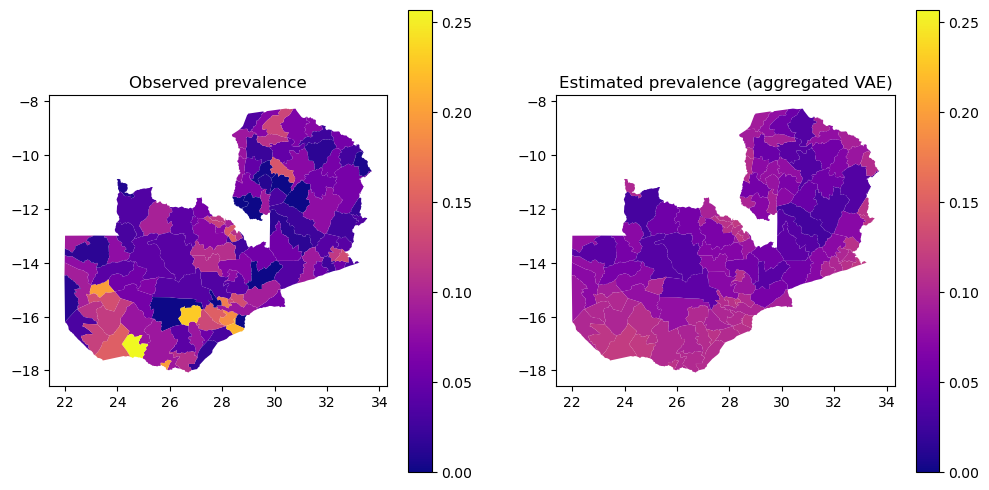

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[n_old:(n_old + n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[n_old:(n_old + n_new)].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (aggregated VAE)')

Text(0.5, 1.0, 'Zambia 2018')

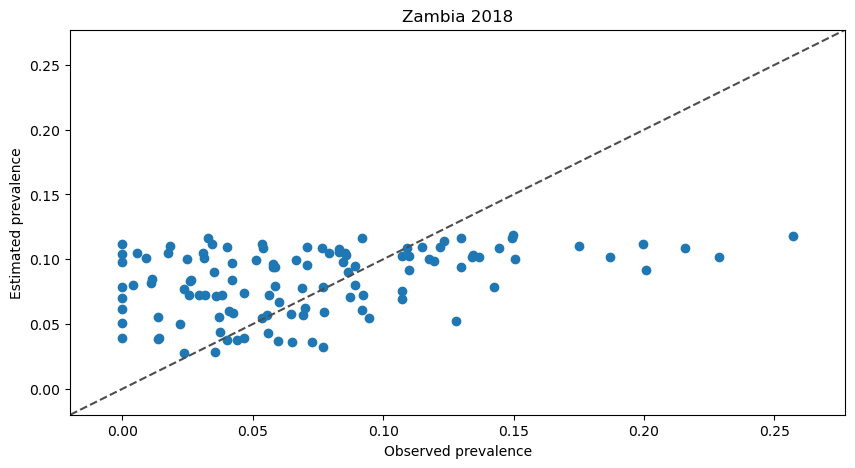

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# ax[0].scatter(s[0:n_old].estimate, s[0:n_old].theta_vae_aggr)
# ax[0].set_ylim(_min-0.02, _max+0.02)
# ax[0].set_xlim(_min-0.02, _max+0.02)
# ax[0].axline((1, 1), slope=1, ls="--", c=".3")
# ax[0].set_xlabel("Observed prevalence")
# ax[0].set_ylabel("Estimated prevalence")
# ax[0].set_title("Before 2010")

# ax[1].scatter(s[n_old:(n_old + n_new)].estimate, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax.scatter(s.estimate, s.theta_vae_aggr)
ax.set_ylim(_min-0.02, _max+0.02)
ax.set_xlim(_min-0.02, _max+0.02)
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.set_xlabel("Observed prevalence")
ax.set_ylabel("Estimated prevalence")
ax.set_title("Zambia 2018")

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/est_obs_vae.pdf')

In [ ]:
def prev_model_gp_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_old = args["M_old"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    var = numpyro.sample("kernel_var", dist.HalfNormal(0.05))
    k = gp_kernel(x, x, var, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f))
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))

    # linear predictor
    lp = b0 + gp_aggr
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [ ]:
# Load
#with open('MCMCs/prev_model_gp_aggr_joint_500iter_lsIG3_3', 'rb') as file:
#    mcmc_gp_aggr = pickle.load(file)

#prev_samples_aggr = mcmc_gp_aggr.get_samples()
#mcmc_gp_aggr.print_summary(exclude_deterministic=False)

In [ ]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_gp_aggr, prev_samples_aggr)(random.PRNGKey(1), args)

theta_samps_gp = prev_posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp
theta_estimated_gp = s['theta_gp']

NameError: name 'prev_samples_aggr' is not defined

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(s[0:n_old].theta_gp, s[0:n_old].theta_vae_aggr)
ax[0].set_ylim(_min-0.02, _max+0.02)
ax[0].set_xlim(_min-0.02, _max+0.02)
ax[0].axline((1, 1), slope=1, ls="--", c=".3")
ax[0].set_xlabel("estimated prev (aggGP)")
ax[0].set_ylabel("estimated prev (aggVAE)")
ax[0].set_title("before 2010")

ax[1].scatter(s[n_old:(n_old + n_new)].theta_gp, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax[1].set_ylim(_min-0.02, _max+0.02)
ax[1].set_xlim(_min-0.02, _max+0.02)
ax[1].axline((1, 1), slope=1, ls="--", c=".3")
ax[1].set_xlabel("estimated prev (aggGP)")
ax[1].set_ylabel("estimated prev (aggVAE)")
ax[1].set_title("after 2010")

In [ ]:
# 1
_max = np.max([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])
_min = np.min([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Before: Observed prev')
ax[1].set_title( 'Before: Estimated prev (aggGP)')
ax[2].set_title( 'Before: Estimated prev (aggVAE)')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[n_old:(n_old+n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'After: Observed prev')
ax[1].set_title( 'After: Estimated prev (aggGP)')
ax[2].set_title( 'After: Estimated prev (aggVAE)')